In [13]:
%load_ext autoreload
%autoreload 2

In [79]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.data.data import load_hires_constants, make_dataset_consistent, filter_by_lat_lon
from dsrnngan.evaluation.plots import lake_feature

In [145]:
lat_range_list = list(np.arange(-11.95, 15.05, 0.1))
lon_range_list = list(np.arange(25.05, 51.35, 0.1))

special_areas = {'Lake Victoria': {'lat_range': [-3.05,0.95], 'lon_range': [31.55, 34.55], 'color': 'red'},
                 'Coastal Kenya/Somalia': {'lat_range': [-4.65, 5.45], 'lon_range': [38.85, 48.3], 'color': 'black'},
                 'West EA Rift': {'lat_range': [-4.70,0.30], 'lon_range': [28.25,31.3], 'color': 'green'},
                 'East EA Rift': {'lat_range': [-3.15, 1.55], 'lon_range': [33.85,36.55], 'color': 'purple'},
                 'NW Ethiopian Highlands': {'lat_range': [6.10, 14.15], 'lon_range': [34.60, 40.30], 'color': 'blue'}}

for k, v in special_areas.items():
    lat_vals = [lt for lt in lat_range_list if v['lat_range'][0] <= lt <= v['lat_range'][1]]
    lon_vals = [ln for ln in lon_range_list if v['lon_range'][0] <= ln <= v['lon_range'][1]]
    
    if lat_vals and lon_vals:
        special_areas[k]['lat_index_range'] = [lat_range_list.index(lt) for lt in lat_vals]
        special_areas[k]['lon_index_range'] = [lon_range_list.index(ln) for ln in lon_vals]


In [139]:
oro_ds = xr.load_dataset('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/h_HRES_EAfrica.nc')
oro_ds = filter_by_lat_lon(oro_ds, lon_range=lon_range_list, lat_range=lat_range_list)
oro_ds = make_dataset_consistent(oro_ds)
h_vals = oro_ds['h'].values
h_vals[h_vals < 5] = 5.0


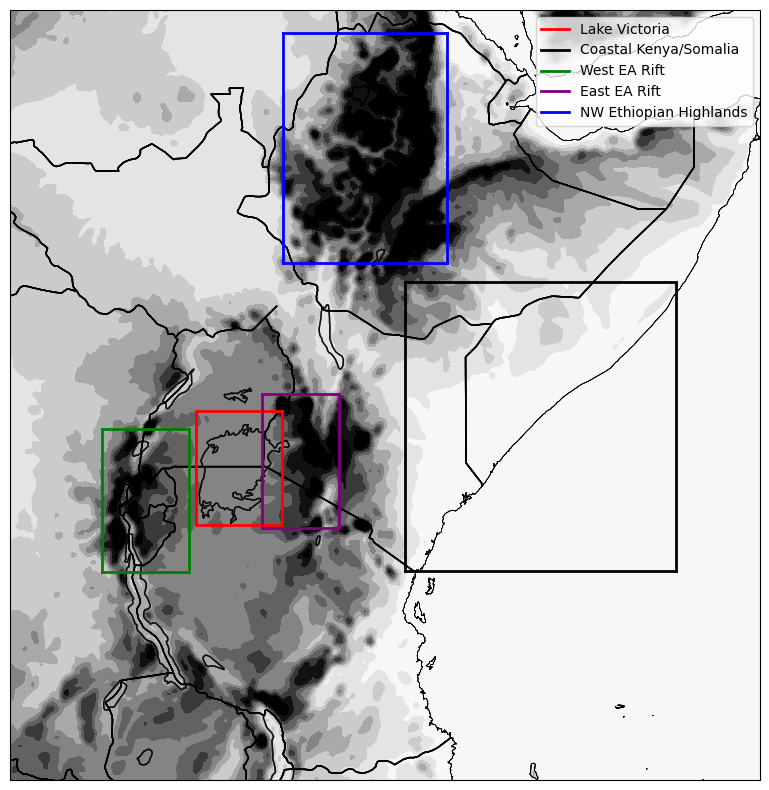

In [146]:

fig, ax = plt.subplots(1,1, subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(10,10))

for k, sa_dict in special_areas.items():
    ax.contourf(lon_range_list, lat_range_list, h_vals[0,:,:], transform=ccrs.PlateCarree(), cmap='Greys', 
                levels=[0] + list(np.arange(250, 2250, 250)), extend='both')#
    ax.coastlines(resolution='10m', color='black', linewidth=0.4)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(lake_feature, alpha=0.4)
    ln_rng, lt_rng = sa_dict['lon_range'], sa_dict['lat_range']

    ax.plot([ln_rng[0], ln_rng[0]], [lt_rng[0], lt_rng[1]], color=sa_dict['color'], linestyle='-', linewidth=2,transform=ccrs.PlateCarree())
    ax.plot([ln_rng[1], ln_rng[1]], [lt_rng[0], lt_rng[1]], color=sa_dict['color'], linestyle='-', linewidth=2,transform=ccrs.PlateCarree())
    ax.plot([ln_rng[0], ln_rng[1]], [lt_rng[0], lt_rng[0]], color=sa_dict['color'], linestyle='-', linewidth=2,transform=ccrs.PlateCarree())
    ax.plot([ln_rng[0], ln_rng[1]], [lt_rng[1], lt_rng[1]], color=sa_dict['color'], linestyle='-', linewidth=2,transform=ccrs.PlateCarree(), label=k)

ax.legend()
plt.show()